# Idea of Heterodyne demodulation measurements

This a summary of the APR paper on introduction to quantum engineering focused on the readout part with heterodyne measurements

## Representation of the readout signal

The input signal $s(t)$ is assumed to be of the form :

$s(t) = Re\{A_{RO}e^{j\theta_{RO}}e^{j\omega_{RO}t}\}$

Where the phasor contains the information for the in-phase and quadrature component:

$A_{RO}e^{j\theta_{RO}}=A_{RO}\cos{\theta_{RO}}+jA_{RO}\sin{\theta_{RO}}\equiv{I+jQ}$


## Heterodyne demodulation

This measurements is processed in several steps.
1. Mixing of the output signal, $s(t)$ at frequency $\omega_{RO}$, with a local oscillator at frequency $\omega_{LO}$, such that $\omega_{IF}=\left|\omega_{RO}-\omega_{LO}\right|>0$. The signals are extracted. We then obtain $I_{IF}\left(t\right)\propto \cos{\left(\omega_{IF}t+\theta_{RPO}\right)}$ and $Q_{IF}\left(t\right)\propto \sin{\left(\omega_{IF}t+\theta_{RPO}\right)}$ with a $\pi/2$ phase. 


2. Using Analog-to-Digital Converters (ADCs), we digitalized the signal, to generate $I_{IF}\left[n\right]\propto \cos{\left(\Omega_{IF}n+\theta_{RPO}\right)}$ and $Q_{IF}\left[n\right]\propto \sin{\left(\Omega_{IF}n+\theta_{RPO}\right)}$, with $n=t/\Delta{t}$ the sample number over the continuous time, $\Omega_{IF}=\omega_{IF}\Delta{t}$ the digital frequency and $\Delta{t}$ the sampling period. (Part 1. can be performed at the same time as part 2. in the FPGA.


Before continuing the measurement process, we can introduce the analytic function, $z_{IF}\left[n\right]$,defined in the complex plane I-Q.

$z_{IF}\left[n\right] = I_{IF}\left[n\right]+jQ_{IF}\left[n\right] \equiv V_I\left[n\right] + jV_Q\left[n\right]$

$= \frac{A_{RO}A_{LO}}{8}\left[cos{\left(\Omega_{IF}n+\theta_{RPO}\right)}+jsin{\left(\Omega_{IF}n+\theta_{RPO}\right)}\right]$

$= \frac{A_{RO}A_{LO}}{8}e^{j\theta_{RO}}e^{j\Omega_{IF}n}$

3. Now we extract the $z_{IF}\left[n\right]$ after a time $\tau_{rd}$ so that our signal is stabilized, which correspond of extracting the signal in a range $[n_1:n_2]$.


4. Finally we demodulate the time serie multiplying point by point $z_{IF}\left[n\right]$ by $e^{-j\Omega_{IF}n}$ to extract the phasor term.

$z\left[n\right] = z_{IF}\left[n\right].*e^{-j\Omega_{IF}n}$

5. Averaging all the points


6. Repeat the procedure a high number of time to reconstruct the map. In the review paper it's indicated $10^6$ times.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

from scipy import signal
%matplotlib inline

### Time Sampling

In the real measurements this part will only be needed in the Analog to Digital Conversion

In [70]:
#Proper time discretization

def TimeSampling(t,dt):
    n = t/dt
    n_array = np.arange(0,t,dt)
    return n,n_array

t = 50/300e3
dt = 10e-8

n_array = TimeSampling(t,dt)[1]
print(n_array,len(n_array))

[0.000e+00 1.000e-07 2.000e-07 ... 1.664e-04 1.665e-04 1.666e-04] 1667


### Generation of the readout signal

Generation of a perfect readout signal, the gaussian noise is added later

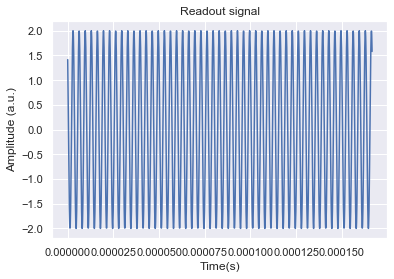

In [37]:
# Generation of the perfect readout signal

def RO(A_RO,freq_RO,theta_RO,n_array):
    Omega_RO = 2*np.pi*freq_RO
    RO = A_RO*np.cos(Omega_RO*n_array + theta_RO)
    return RO

A_RO = 2
freq_RO = 300e3
theta_RO = np.pi/4

plt.title('Readout signal')
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time(s)')

plt.plot(n_array,RO(A_RO,freq_RO,theta_RO,n_array))
plt.show()

### Local Oscillator

In [38]:
#Local Oscillator

freq_IF = 30e3
A_LO = 1
def LO(A_LO,freq_IF,theta_LO,n_array):
    freq_LO = freq_RO - freq_IF
    Omega_LO = 2*np.pi*freq_LO
    LO = A_LO * np.cos(Omega_LO*n_array + theta_LO)
    return LO

### Pulses and mixing

In this part, we proceed to the mixing.

In [39]:
def Pulse(N,N_T,freq_IF,LO,RO,I_noise,n_array):
    Pulses_I = []
    Pulses_Q = []
    N_Period = N_T * freq_IF
    for k in range(N):
        noise = np.random.normal(0,I_noise,len(n_array))
        I = (RO(A_RO,freq_RO,theta_RO,n_array)+noise)*LO(A_LO,freq_IF,0,n_array)
        Q = (RO(A_RO,freq_RO,theta_RO,n_array)+noise)*LO(A_LO,freq_IF,np.pi/2,n_array)
        Pulses_I.append(I)
        Pulses_Q.append(Q)
    return np.asarray(Pulses_I),np.asarray(Pulses_Q)

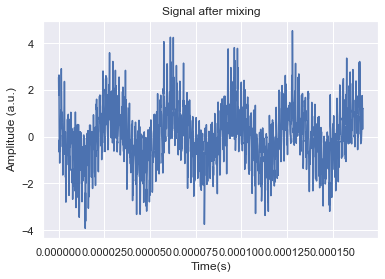

In [72]:
N=10000
I_noise = 1
X = Pulse(N,2,freq_IF,LO,RO,I_noise,n_array)

plt.plot(n_array,X[0][0])

plt.title('Signal after mixing')
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time(s)')
plt.show()

In [73]:
#List of signals after pulse

Is = X[0]
Qs = X[1]

Zs = Is + 1j*Qs



### Filter the pulsed signals

We remove the high frequency component.

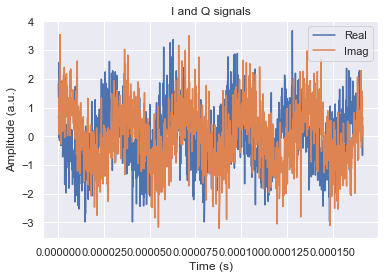

In [74]:
Is_Filter = (Is - np.cos(2*np.pi*(freq_RO+freq_RO-freq_IF)*n_array + theta_RO))
Qs_Filter = (Qs - np.cos(2*np.pi*(freq_RO+freq_RO-freq_IF)*n_array + np.pi/2 + theta_RO))

Zs_IF = Is_Filter + 1j*Qs_Filter


plt.title('I and Q signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')

plt.plot(n_array,Zs_IF.real[0],label='Real')
plt.plot(n_array,Zs_IF.imag[0], label='Imag')
plt.legend()
plt.show()

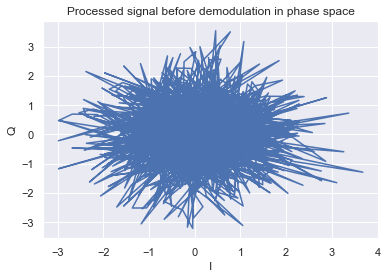

In [75]:
plt.title('Processed signal before demodulation in phase space')
plt.xlabel('I')
plt.ylabel('Q')

plt.plot(Zs_IF.real[0],Zs_IF.imag[0])
plt.show()

In [76]:
Zs = Zs_IF*np.exp(-1j*2*np.pi*freq_IF*n_array) #Why not the complex conjugqte, mystery...

In [77]:
Z_av = []
for k in range(N):
    Z_av.append(1/len(n_array)*sum(Zs[k]))
    
Z_av = np.asarray(Z_av)

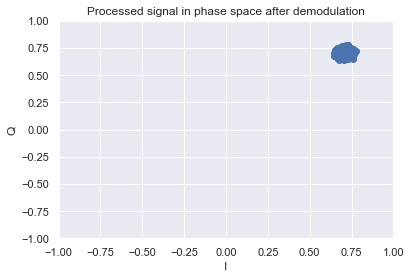

In [78]:
plt.title('Processed signal in phase space after demodulation')
plt.xlabel('I')
plt.ylabel('Q')
plt.scatter(Z_av.real,Z_av.imag)
plt.xlim(-1, 1)
plt.ylim(-1 ,1)
plt.show()

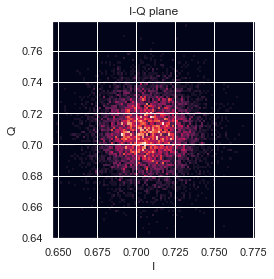

In [79]:
heatmap, xedges, yedges = np.histogram2d(Z_av.real, Z_av.imag, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.title('I-Q plane')
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

In [80]:
#Average of the average

Z_av2 = 1/N*sum(Z_av)

Phase = np.angle(Z_av2)
Norm = np.sqrt(Z_av2.real**2+Z_av2.imag**2)
print('Phase:',Phase,'Norm:',Norm)

Phase: 0.7853242942080534 Norm: 1.0000930954863279


In [81]:
#Comparison to the initial phase

print(Phase-theta_RO)

-7.386918939489284e-05


### Covariance matrix

We're now aiming at obtaining the one mode covariance matrix defined in the compact notation as:

$$\left[\sigma\right]_{kj}=\frac{1}{2}\left<\{\hat{R}_k,\hat{R}_j\}\right>-\left<\hat{R}_j\right>\left<\hat{R}_k\right>$$

In [82]:
p = Z_av.real
q = Z_av.imag

S = np.zeros(shape=(2,2))

S[0,0] = 1/len(q)*(sum(q**2) - sum(q)**2)
S[1,1] = 1/len(p)*(sum(p**2) - sum(p)**2)
S[0,1] = 1/(2*len(q))*sum(q*p+p*q)-1/(len(q)**2)*sum(q)*sum(p)
S[1,0] = S[0,1]

print(S)

[[-4.99969185e+03  1.13132131e-06]
 [ 1.13132131e-06 -5.00116936e+03]]


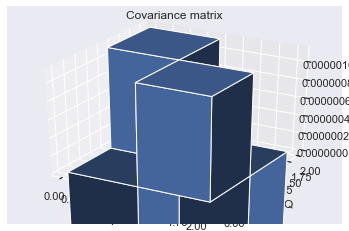

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_data, y_data = np.meshgrid( np.arange(S.shape[1]),
                              np.arange(S.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = S.flatten()
ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)), 
          1, 1, z_data )
plt.title('Covariance matrix')
plt.xlabel('P')
plt.ylabel('Q')
#ax.set_zlim(-10, 10)
plt.savefig('t.png')
plt.show()

Find a way to make that nice

array([-4.99965702e+03, -1.54970796e-08, -1.54970796e-08, -4.99948413e+03])

Coucou